# Лабораторная работа №4 “Нейронные сети”

### *Набор данных **ex4data1.mat** (такой же, как в лабораторной работе №2) представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит 5000 изображений 20x20 в оттенках серого. Каждый пиксель представляет собой значение яркости (вещественное число). Каждое изображение сохранено в виде вектора из 400 элементов. В результате загрузки набора данных должна быть получена матрица 5000x400. Далее расположены метки классов изображений от 1 до 9 (соответствуют цифрам от 1 до 9), а также 10 (соответствует цифре 0).*

## **Задание**

### 1. Загрузите данные **ex4data1.mat** из файла.

In [35]:
from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt

from scipy import io

from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [4]:
ex4data1 = io.loadmat('Data/Lab 4/ex4data1.mat')
X, y = ex4data1['X'], ex4data1['y'].flatten()

### 2. Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ<sup>(1)</sup> (25, 401) и Θ<sup>(2)</sup> (10, 26). Какова структура полученной нейронной сети?

In [5]:
ex4weights = io.loadmat('Data/Lab 4/ex4weights.mat')
theta1, theta2 = ex4weights['Theta1'], ex4weights['Theta2']

Структура сети: двухслойная полносвязная сеть

### 3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации.

In [8]:
class SigmoidLayer:
    def __init__(self):
        pass

    def forward(self, X):
        return np.ones_like(X) / (np.ones_like(X) + np.exp(-X))

In [6]:
class Param:
    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)
        

class FullyConnectedLayer:
    def __init__(self, W, B):
        self.W = Param(W)
        self.B = Param(B)
        
        self.X = None

    def forward(self, X):
        self.X = X
        result = self.X @ self.W.value + self.B.value

        return result
    
    
class TwoLayerNet:
    def __init__(self, W1, W2, B1, B2):
        self.fc1 = FullyConnectedLayer(W1, B1)
        self.fc2 = FullyConnectedLayer(W2, B2)
        
        self.sigmoid = SigmoidLayer()
    
    def forward(self, X):
        predictions = self.fc1.forward(X)
        predictions = self.sigmoid.forward(predictions)
        predictions = self.fc2.forward(predictions)
        
        return predictions
        
    def predict(self, X):
        predictions = self.forward(X)
        pred = np.argmax(predictions, axis=1)

        return pred

### 4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

In [9]:
theta1_tr, theta2_tr = theta1.transpose(), theta2.transpose()
W1, W2 = theta1_tr[1:, :], theta2_tr[1:, :]
B1, B2 = theta1_tr[0, :], theta2_tr[0, :]

model = TwoLayerNet(W1, W2, B1, B2)

predictions = model.predict(X)

In [12]:
def multiclass_accuracy(prediction, ground_truth):
    right_predictions = prediction == ground_truth
    accuracy = right_predictions.sum() / right_predictions.shape[0]

    return accuracy

nn_accuracy = multiclass_accuracy(predictions, y-1)

print('Correct answers percent: {:.2%} (log regression: 94.76%)'.format(nn_accuracy))

Correct answers percent: 97.52% (log regression: 94.76%)


### 5. Перекодируйте исходные метки классов по схеме one-hot.

In [15]:
label_encoder = OneHotEncoder(categories='auto')
y_one_hot = label_encoder.fit_transform(y.reshape(-1, 1)).toarray()

### 6. Реализуйте функцию стоимости для данной нейронной сети.

In [16]:
def softmax_with_cross_entropy(predictions, target_index):
    predictions = predictions - np.max(predictions, axis=1)[:, np.newaxis]
    exponents = np.exp(predictions)
    softmax_values = exponents / np.sum(exponents, axis=1)[:, np.newaxis]

    loss = -np.log(softmax_values[range(softmax_values.shape[0]), target_index])
    loss = np.sum(loss)

    dprediction = softmax_values
    dprediction[range(dprediction.shape[0]), target_index] -= 1

    return loss, dprediction

### 7. Добавьте L2-регуляризацию в функцию стоимости.

In [17]:
def l2_regularization(W, reg_strength):
    loss = reg_strength * np.sum(W**2)
    grad = reg_strength * 2 * W

    return loss, grad

### 8. Реализуйте функцию вычисления производной для функции активации.

In [18]:
class SigmoidLayer:
    def __init__(self):
        self.sigmoid_value = None

    def forward(self, X):
        self.sigmoid_value = np.ones_like(X) / (np.ones_like(X) + np.exp(-X))
        return self.sigmoid_value 
    
    def backward(self, d_out):
        d_sigmoid = (np.ones_like(self.sigmoid_value) - self.sigmoid_value) * self.sigmoid_value
        
        return d_out * d_sigmoid

    def params(self):
        return {}
    

class FullyConnectedLayer:
    def __init__(self, W, B):
        self.W = Param(W)
        self.B = Param(B)
        
        self.X = None

    def forward(self, X):
        self.X = X
        result = self.X @ self.W.value + self.B.value

        return result
    
    def backward(self, d_out):
        d_input = d_out @ self.W.value.T

        self.W.grad = self.X.T @ d_out
        self.B.grad = np.sum(d_out, axis=0) * np.ones_like(self.B.value)

        return d_input

    def params(self):
        return {'W': self.W, 'B': self.B}

### 9. Инициализируйте веса небольшими случайными числами.

In [19]:
model = TwoLayerNet(
    W1=np.random.randn(400, 25), 
    W2=np.random.randn(25, 10), 
    B1=np.random.randn(25), 
    B2=np.random.randn(10)
)

### 10. Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.

In [20]:
class TwoLayerNet:
    def __init__(self, W1, W2, B1, B2, reg):
        self.fc1 = FullyConnectedLayer(W1, B1)
        self.sigmoid = SigmoidLayer()
        self.fc2 = FullyConnectedLayer(W2, B2)
        self.reg = reg
           
    def forward(self, X):
        predictions = self.fc1.forward(X)
        predictions = self.sigmoid.forward(predictions)
        predictions = self.fc2.forward(predictions)
        
        return predictions
        
    def predict(self, X):
        predictions = self.forward(X)
        pred = np.argmax(predictions, axis=1)

        return pred
    
    def compute_loss_and_gradients(self, X, y):
        for param in self.params().values():
            param.grad = np.zeros_like(param.grad)

        predictions = self.forward(X)
        cross_entropy_loss, dpredictions = softmax_with_cross_entropy(predictions, y)
 
        dpredictions = self.fc2.backward(dpredictions)
        dpredictions = self.sigmoid.backward(dpredictions)
        dpredictions = self.fc1.backward(dpredictions)
        dX = dpredictions

        total_regularization_loss = 0
        for param in self.params().values():
            l2_loss, l2_grad = l2_regularization(param.value, self.reg)

            param.grad += l2_grad
            total_regularization_loss += l2_loss

        loss = cross_entropy_loss + total_regularization_loss

        return loss

    def params(self):
        result = {
            'W1': self.fc1.W,
            'B1': self.fc1.B,
            'W2': self.fc2.W,
            'B2': self.fc2.B
        }

        return result

### 11. Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10-4.

In [21]:
def check_gradient(f, x, delta=1e-5, tol=1e-6):
    
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float
    
    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), "Functions shouldn't modify input variables"

    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()

    # We will go through every dimension of x and compute numeric
    # derivative for it
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]

        h = np.zeros_like(x)
        h[ix] += 1

        numeric_grad_at_ix = (f(x + delta*h)[0] - f(x - delta*h)[0]) / (2 * delta)

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True


def check_model_gradient(model, X, y, delta=1e-5, tol=1e-6):
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True

In [22]:
model = TwoLayerNet(
    W1=np.random.randn(400, 25), 
    W2=np.random.randn(25, 10), 
    B1=np.random.randn(25), 
    B2=np.random.randn(10),
    reg=0
)

In [23]:
batch_size = 1
check_model_gradient(
    model, 
    X[:batch_size], 
    y_one_hot.argmax(axis=1)[:batch_size],
    delta=1e-6,
    tol=1e-4
)

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

### 12. Добавьте L2-регуляризацию в процесс вычисления градиентов.

In [24]:
model = TwoLayerNet(
    W1=np.random.randn(400, 25), 
    W2=np.random.randn(25, 10), 
    B1=np.random.randn(25), 
    B2=np.random.randn(10),
    reg=1e-4
)

### 13. Проверьте полученные значения градиента.

In [25]:
batch_size = 1

check_model_gradient(
    model, 
    X[:batch_size], 
    y_one_hot.argmax(axis=1)[:batch_size],
    delta=1e-6,
    tol=1e-4
)

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

### 14. Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.

In [26]:
class SGD:
    def update(self, w, d_w, learning_rate):
        return w - d_w * learning_rate

In [34]:
class Trainer:
    def __init__(self, model, train_X, train_y, optim,
                 num_epochs=20,
                 batch_size=20,
                 learning_rate=1e-2):
        self.train_X, self.train_y = train_X, train_y
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.optimizers = None

    def setup_optimizers(self):
        params = self.model.params()
        self.optimizers = {}
        for param_name, param in params.items():
            self.optimizers[param_name] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return multiclass_accuracy(pred, y)

    def fit(self):
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for epoch in range(self.num_epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                x_batch, y_batch = self.train_X[batch_indices], self.train_y[batch_indices]
                loss = self.model.compute_loss_and_gradients(x_batch, y_batch)

                for param_name, param in self.model.params().items():
                    optimizer = self.optimizers[param_name]
                    param.value = optimizer.update(param.value, param.grad, self.learning_rate)

                batch_losses.append(loss)

                batch_accuracy = self.compute_accuracy(x_batch, y_batch)

            ave_loss = np.mean(batch_losses)
            train_accuracy = self.compute_accuracy(self.train_X, self.train_y)

            print('Loss: %f, Train accuracy: %f' %(batch_losses[-1], train_accuracy))

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)

        return loss_history, train_acc_history

In [32]:
model = TwoLayerNet(
    W1=np.random.randn(400, 25), 
    W2=np.random.randn(25, 10), 
    B1=np.random.randn(25), 
    B2=np.random.randn(10),
    reg=0
)

optim = SGD()

trainer = Trainer(model=model, train_X=X, train_y=y_one_hot.argmax(axis=1), optim=optim, num_epochs=200)

In [33]:
loss_history, train_acc_history = trainer.fit()

Loss: 26.160409, Train accuracy: 0.654800
Loss: 19.183639, Train accuracy: 0.752400
Loss: 10.996868, Train accuracy: 0.795200
Loss: 12.057975, Train accuracy: 0.825200
Loss: 6.575583, Train accuracy: 0.847000
Loss: 7.912921, Train accuracy: 0.859200
Loss: 5.131373, Train accuracy: 0.873400
Loss: 3.233536, Train accuracy: 0.883400
Loss: 13.987534, Train accuracy: 0.889600
Loss: 7.053924, Train accuracy: 0.893600
Loss: 8.170688, Train accuracy: 0.899400
Loss: 5.111119, Train accuracy: 0.904000
Loss: 4.527087, Train accuracy: 0.908600
Loss: 6.365131, Train accuracy: 0.909800
Loss: 6.578419, Train accuracy: 0.914200
Loss: 6.920670, Train accuracy: 0.918400
Loss: 8.995279, Train accuracy: 0.923000
Loss: 7.739378, Train accuracy: 0.925000
Loss: 1.573313, Train accuracy: 0.925600
Loss: 5.273497, Train accuracy: 0.931000
Loss: 5.904334, Train accuracy: 0.930800
Loss: 2.467284, Train accuracy: 0.934600
Loss: 3.217251, Train accuracy: 0.936200
Loss: 4.909436, Train accuracy: 0.938400
Loss: 1.766

### 15. Вычислите процент правильных классификаций на обучающей выборке.

In [37]:
print('Correct answers percent: {:.2%}'.format(train_acc_history[-1]))

Correct answers percent: 99.82%


### 16. Визуализируйте скрытый слой обученной сети.

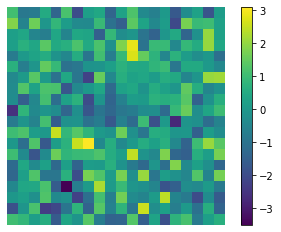

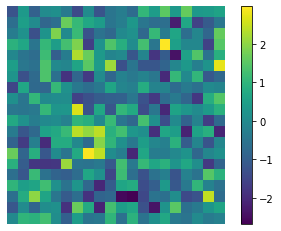

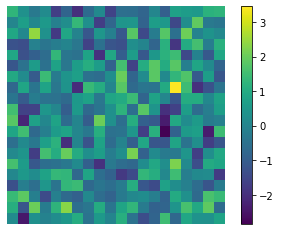

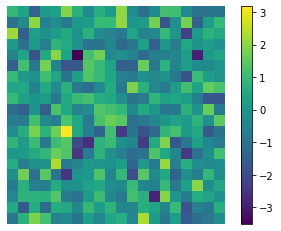

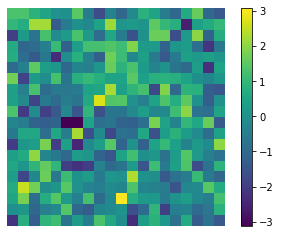

In [38]:
W1_trained = model.fc1.W.value
W1_trained_reshaped = W1_trained.reshape((20, 20, 25)).transpose()

for W in W1_trained_reshaped[:5]:
    plt.imshow(W.transpose())
    plt.axis('off')
    plt.colorbar()
    plt.show()

### 17. Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

In [39]:
model = TwoLayerNet(
    W1=np.random.randn(400, 25), 
    W2=np.random.randn(25, 10), 
    B1=np.random.randn(25), 
    B2=np.random.randn(10),
    reg=0.01
)

optim = SGD()

trainer = Trainer(model=model, train_X=X, train_y=y_one_hot.argmax(axis=1), optim=optim, num_epochs=100)

In [40]:
loss_history, train_acc_history = trainer.fit()

Loss: 111.242459, Train accuracy: 0.705400
Loss: 101.842707, Train accuracy: 0.777400
Loss: 92.507639, Train accuracy: 0.823000
Loss: 83.891129, Train accuracy: 0.842200
Loss: 68.677069, Train accuracy: 0.861800
Loss: 70.644903, Train accuracy: 0.874200
Loss: 58.222038, Train accuracy: 0.887400
Loss: 57.686724, Train accuracy: 0.892600
Loss: 51.042550, Train accuracy: 0.902000
Loss: 44.543845, Train accuracy: 0.910000
Loss: 41.389907, Train accuracy: 0.915000
Loss: 39.411872, Train accuracy: 0.916200
Loss: 36.491608, Train accuracy: 0.923400
Loss: 37.832826, Train accuracy: 0.924400
Loss: 29.675773, Train accuracy: 0.931200
Loss: 33.648829, Train accuracy: 0.930400
Loss: 27.153354, Train accuracy: 0.931400
Loss: 23.030643, Train accuracy: 0.934800
Loss: 21.720122, Train accuracy: 0.939000
Loss: 21.349460, Train accuracy: 0.938400
Loss: 20.262971, Train accuracy: 0.941600
Loss: 18.886814, Train accuracy: 0.939400
Loss: 17.355865, Train accuracy: 0.944600
Loss: 22.300300, Train accuracy:

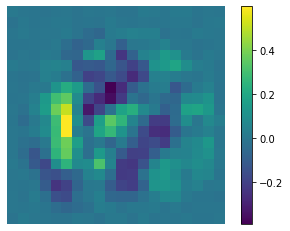

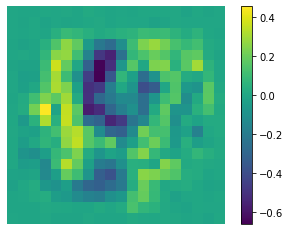

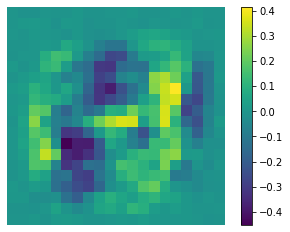

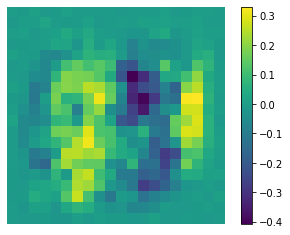

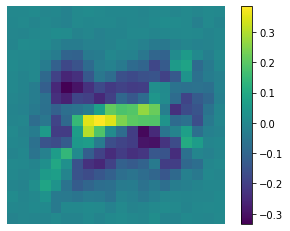

In [41]:
W1_trained = model.fc1.W.value
W1_trained_reshaped = W1_trained.reshape((20, 20, 25)).transpose()

for W in W1_trained_reshaped[:5]:
    plt.imshow(W.transpose())
    plt.axis('off')
    plt.colorbar()
    plt.show()

Мы видим, что по краям изображений становится мало информации, а значит веса там близки к нулю. 